# Proyecto 1: Denoising Autoencoder (DAE) y Variational Autoencoder (VAE) para Restauración y Generación de Imágenes

### Melanie Michel Rodriguez
### Ilse Regina Flores Reyes
### Santiago Aguirre Vera

El objetivo de este proyecto es desarrollar y entrenar dos modelos de aprendizaje profundo aplicados a la restauración y generación de imágenes. El proyecto se realizará en equipos de hasta 3 integrantes y constará de las siguientes etapas:


### Librerias


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 MB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 111.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 6.3 MB/s eta 0:00:00


In [26]:
#Librerías
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, Model
from tensorflow.keras.layers import Lambda, Flatten, Dense, Reshape
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from PIL import Image
import wandb
import matplotlib.pyplot as plt
import gradio as gr
from google.colab import files
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint

##Parte 1: Creación del Dataset

**Obtención de imágenes:**

Los equipos deberán recolectar imágenes de al menos dos clases distintas mediante web scraping.

Se pueden utilizar extensiones de Chrome o librerías de web scraping en Python (ej. BeautifulSoup, Scrapy, Selenium).

Es necesario documentar el proceso de recopilación de datos.

**Procesamiento de datos:**

Normalizar las imágenes y organizarlas en conjuntos de entrenamiento, validación y prueba.

Se recomienda utilizar herramientas como OpenCV o PIL para el preprocesamiento.

In [9]:
# Definir rutas
dataset_path = "/content/drive/MyDrive/data"  # Reemplaza con tu ruta
IMG_SIZE = (128, 128)  # Tamaño de las imágenes
classes = ["coca", "sprite"] #, "Lata Pepsi"]

In [10]:
def resize_with_padding(img, target_size):
    old_size = img.shape[:2]  # (alto, ancho)
    ratio = min(target_size[0] / old_size[0], target_size[1] / old_size[1])
    new_size = tuple([int(x * ratio) for x in old_size])

    img_resized = cv2.resize(img, (new_size[1], new_size[0]), interpolation=cv2.INTER_AREA)

    delta_w = target_size[1] - new_size[1]
    delta_h = target_size[0] - new_size[0]
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)

    # Rellenar con blanco (255)
    color = [255, 255, 255]
    new_img = cv2.copyMakeBorder(img_resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)

    return new_img

# Cargar imágenes con padding
def load_images_with_padding(folder, img_size):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        try:
            img = load_img(img_path)  # Cargar imagen sin redimensionar
            img = img_to_array(img).astype(np.uint8)  # Convertir a array
            img = resize_with_padding(img, img_size)  # Aplicar padding
            img = img / 255.0  # Normalizar
            images.append(img)
        except Exception as e:
            print(f"Error al cargar {img_path}: {e}")
    return np.array(images)

# Cargar todas las imágenes con la nueva función
all_images = []
all_labels = []

for idx, class_name in enumerate(classes):
    class_path = os.path.join(dataset_path, class_name)
    images = load_images_with_padding(class_path, IMG_SIZE)
    all_images.extend(images)
    all_labels.extend([idx] * len(images))

# Convertir a arrays de NumPy
all_images = np.array(all_images)
all_labels = np.array(all_labels)

# División en conjunto de entrenamiento y prueba
x_train, x_test, y_train, y_test = train_test_split(all_images, all_labels, test_size=0.2, random_state=42)

print(f"Imágenes de entrenamiento: {x_train.shape}")
print(f"Imágenes de prueba: {x_test.shape}")

Imágenes de entrenamiento: (102, 128, 128, 3)
Imágenes de prueba: (26, 128, 128, 3)


## Parte 2: Denoising Autoencoder (DAE)
**Entrenamiento:**

Se debe construir un Autoencoder para eliminar ruido de las imágenes.

**Se ensuciarán las imágenes del conjunto de entrenamiento de forma sintética con técnicas como:**

Ruido Gaussiano

Ruido de sal y pimienta

El modelo deberá ser evaluado con imágenes de prueba que también han sido ensuciadas.

**Tracking en Weights & Biases:**

Registrar el entrenamiento, métricas y pérdidas en Weights & Biases (W&B).

Se debe incluir un reporte de W&B con los logs obtenidos.

In [11]:
# Encoder
input_img = layers.Input(shape=(128, 128, 3))
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

In [12]:
# Agregar ruido a las imágenes
def add_gaussian_noise(images, mean=0, std=0.1):
    noise = np.random.normal(mean, std, images.shape)
    noisy_images = images + noise
    noisy_images = np.clip(noisy_images, 0, 1)  # Asegurar que los valores estén en [0, 1]
    return noisy_images

x_train_noisy = add_gaussian_noise(x_train)
x_test_noisy = add_gaussian_noise(x_test)

In [13]:
# Cargar modelo en Weights and Biases
wandb.init(project="denoising-autoencoder")
autoencoder.fit(x_train_noisy, x_train, epochs=50, batch_size=32,
                validation_data=(x_test_noisy, x_test),
                callbacks=[wandb.keras.WandbMetricsLogger(),
                           wandb.keras.WandbModelCheckpoint(filepath="model_{epoch:02d}.h5")])

wandb.finish()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: melaniemichelrod (melaniemichelrod-iteso) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 899ms/step - loss: 0.1711

4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - loss: 0.1685 - val_loss: 0.0792
Epoch 2/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0762

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0777 - val_loss: 0.0996
Epoch 3/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0904 

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.0870 - val_loss: 0.0677
Epoch 4/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0662 

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.0658 - val_loss: 0.0580
Epoch 5/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0516 

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.0517 - val_loss: 0.0472
Epoch 6/50
2/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0420

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step - loss: 0.0414 - val_loss: 0.0349
Epoch 7/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0316

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0306 - val_loss: 0.0254
Epoch 8/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0223 

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - loss: 0.0219 - val_loss: 0.0216
Epoch 9/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0188

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0183 - val_loss: 0.0207
Epoch 10/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0155 

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - loss: 0.0158 - val_loss: 0.0198
Epoch 11/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0152 

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.0150 - val_loss: 0.0166
Epoch 12/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0131

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0131 - val_loss: 0.0149
Epoch 13/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0121

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.0120 - val_loss: 0.0150
Epoch 14/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0114

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0114 - val_loss: 0.0135
Epoch 15/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0105

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0106 - val_loss: 0.0132
Epoch 16/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0105

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.0105 - val_loss: 0.0129
Epoch 17/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0110 

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.0108 - val_loss: 0.0124
Epoch 18/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0095 

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - loss: 0.0096 - val_loss: 0.0125
Epoch 19/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0105 

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - loss: 0.0102 - val_loss: 0.0120
Epoch 20/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0092 

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - loss: 0.0093 - val_loss: 0.0113
Epoch 21/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0087 

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - loss: 0.0088 - val_loss: 0.0125
Epoch 22/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0090

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.0091 - val_loss: 0.0114
Epoch 23/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0084

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.0085 - val_loss: 0.0108
Epoch 24/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0085

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.0084 - val_loss: 0.0109
Epoch 25/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0087 

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 0.0085 - val_loss: 0.0104
Epoch 26/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0081

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.0080 - val_loss: 0.0110
Epoch 27/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0080

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.0080 - val_loss: 0.0107
Epoch 28/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0080

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.0079 - val_loss: 0.0101
Epoch 29/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0083 

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.0082 - val_loss: 0.0112
Epoch 30/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0080 

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.0082 - val_loss: 0.0132
Epoch 31/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0098

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.0094 - val_loss: 0.0096
Epoch 32/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0068

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0070 - val_loss: 0.0093
Epoch 33/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0073

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0071 - val_loss: 0.0091
Epoch 34/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0068

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0068 - val_loss: 0.0089
Epoch 35/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0065

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.0065 - val_loss: 0.0088
Epoch 36/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0063 

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - loss: 0.0064 - val_loss: 0.0090
Epoch 37/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0064 

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - loss: 0.0064 - val_loss: 0.0086
Epoch 38/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0059 

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 0.0061 - val_loss: 0.0084
Epoch 39/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0062

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.0062 - val_loss: 0.0084
Epoch 40/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0060

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.0061 - val_loss: 0.0082
Epoch 41/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0060 

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - loss: 0.0060 - val_loss: 0.0081
Epoch 42/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0054 

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - loss: 0.0056 - val_loss: 0.0079
Epoch 43/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0062

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step - loss: 0.0060 - val_loss: 0.0078
Epoch 44/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0058

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.0058 - val_loss: 0.0079
Epoch 45/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0059 

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step - loss: 0.0059 - val_loss: 0.0079
Epoch 46/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0056

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 311ms/step - loss: 0.0057 - val_loss: 0.0077
Epoch 47/50
2/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0058 

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step - loss: 0.0057 - val_loss: 0.0077
Epoch 48/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0058

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 406ms/step - loss: 0.0057 - val_loss: 0.0075
Epoch 49/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0055 

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step - loss: 0.0055 - val_loss: 0.0075
Epoch 50/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0055 

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 214ms/step - loss: 0.0054 - val_loss: 0.0076


epoch/epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_loss,▆█▆▅▄▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.00542
epoch/val_loss,0.00763


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


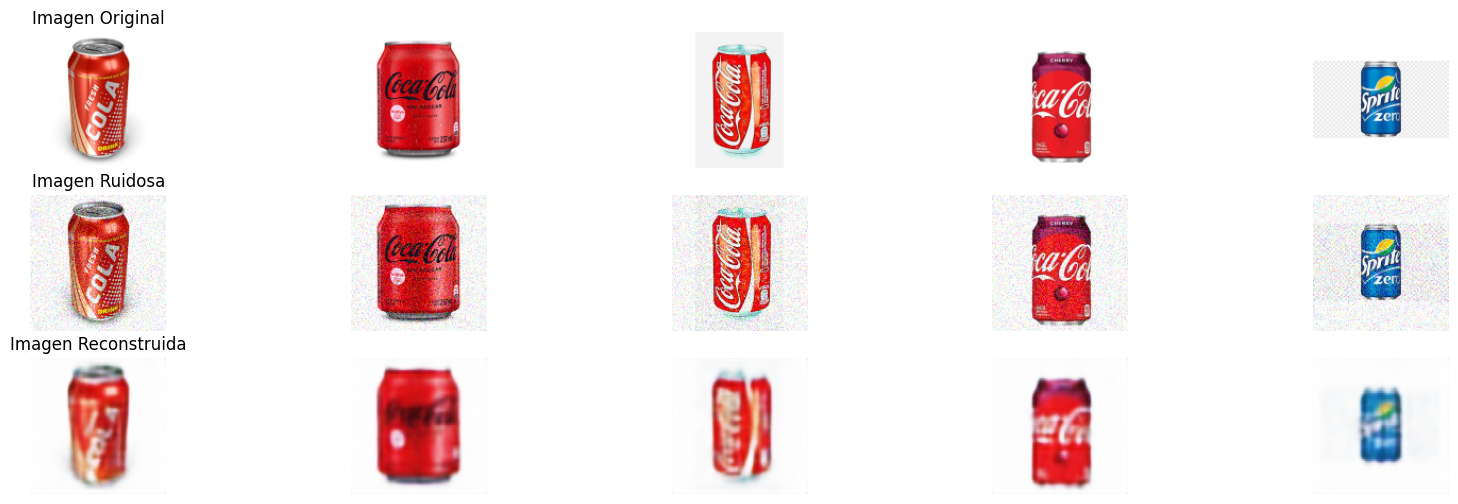

In [16]:
# Generar predicciones con el autoencoder
decoded_imgs = autoencoder.predict(x_test_noisy)

# Número de imágenes a mostrar
n = 5

plt.figure(figsize=(20, 6))
for i in range(n):

    # Imagen original sin ruido
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i])
    plt.axis("off")
    if i == 0:

        ax.set_title("Imagen Original")
    # Imagen original con ruido
    ax = plt.subplot (3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i])
    plt.axis("off")
    if i == 0:
        ax.set_title("Imagen Ruidosa")

    # Imagen reconstruida por el autoencoder
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(decoded_imgs[i])
    plt.axis("off")
    if i == 0:
        ax.set_title("Imagen Reconstruida")

plt.show()

## Parte 3: Variational Autoencoder (VAE) para Generación de Imágenes
**Entrenamiento:**

Implementar un VAE para la generación de imágenes sintéticas de al menos dos clases.

Se utilizarán los datos recolectados en la primera parte como referencia.

**Evaluación de Imágenes Generadas:**

Evaluar la calidad de las imágenes generadas con la métrica desarrollada previamente en la tarea de "Creación de una métrica estilo FID".

Comparar los resultados con las imágenes reales.

**Tracking en Weights & Biases:**

Registrar el entrenamiento, métricas y pérdidas en Weights & Biases.

Se debe incluir un reporte de W&B con los logs obtenidos.

In [18]:
# ENCODER
input_img = layers.Input(shape=(128, 128, 3))  # Entrada de la imagen (128x128x3)

# Primera capa: Extrae características básicas
x = layers.Conv2D(32, (3, 3), padding='same')(input_img)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)  # Reduce a 64x64

# Segunda capa: Extrae características más complejas
x = layers.Conv2DTranspose(128, (5, 5), padding='same')(x)  # Kernel más grande
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.BatchNormalization()(x)

# Tercera capa: Reducción final antes del espacio latente
x = layers.Conv2DTranspose(64, (5, 5), padding='same')(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.BatchNormalization()(x)

# Capa de compresión a espacio latente
x = layers.GlobalAveragePooling2D()(x)  # Comprime a 1D

# Dimensión del espacio latente
z_dim = 128  # Se puede probar con 256 o 512

# Variables latentes
z_mean = layers.Dense(z_dim, name='z_mean')(x)  # Media de la distribución
z_log_var = layers.Dense(z_dim, name='z_log_var')(x)  # Varianza logarítmica


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [19]:
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.random.normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [20]:
# DECODER
decoder_input = layers.Input(shape=(z_dim,))  # Entrada del decoder (vector latente)

# Primera capa: Expande el vector latente a un mapa de características 16x16x128
x = layers.Dense(16 * 16 * 128, activation='relu')(decoder_input)
x = layers.Reshape((16, 16, 128))(x)  # Se convierte en imagen 16x16 con 128 filtros

# Segunda capa: Primer bloque de reconstrucción
x = layers.Conv2DTranspose(128, (3, 3), padding='same')(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.BatchNormalization()(x)
x = layers.UpSampling2D((2, 2))(x)  # Aumenta a 32x32

# Tercera capa: Segundo bloque de reconstrucción
x = layers.Conv2DTranspose(64, (3, 3), padding='same')(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.BatchNormalization()(x)
x = layers.UpSampling2D((2, 2))(x)  # Aumenta a 64x64

# Cuarta capa: Tercer bloque de reconstrucción
x = layers.Conv2DTranspose(32, (3, 3), padding='same')(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.BatchNormalization()(x)
x = layers.UpSampling2D((2, 2))(x)  # Aumenta a 128x128 (tamaño original)

# Última capa: Reconstrucción final con 3 canales de salida (RGB)
decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

In [22]:
def vae_loss(input_img, decoded):
    # Obtener los valores latentes z_mean y z_log_var desde el encoder
    z_mean, z_log_var, _ = encoder(input_img)

    # Pérdida de reconstrucción: Compara la imagen original con la reconstruida
    # Se usa Mean Squared Error (MSE) para medir la diferencia entre input_img y decoded
    reconstruction_loss = tf.reduce_mean(tf.square(input_img - decoded))

    # Pérdida de Divergencia KL: Regulariza la distribución latente para que se acerque a una distribución normal estándar N(0,1)
    # Se usa la fórmula de KL Divergence: -0.5 * Σ(1 + logσ² - μ² - exp(logσ²))
    kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))

    # Retorna la pérdida total como la suma de la reconstrucción y la KL Divergence (ponderada por 0.01)
    return reconstruction_loss + 0.01 * kl_loss

In [23]:
# Capa de muestreo
z = layers.Lambda(sampling, name='z')([z_mean, z_log_var])

# Crear los modelos
encoder = Model(input_img, [z_mean, z_log_var, z], name='encoder')
decoder = Model(decoder_input, decoded, name='decoder')

# Salida del VAE
vae_output = decoder(encoder(input_img)[2])
vae = Model(input_img, vae_output, name='vae')

In [47]:
from tensorflow.keras.applications import DenseNet121

# Cargar DenseNet121 preentrenado (sin la capa fully connected)
dense_net = DenseNet121(include_top=False, input_shape=(128, 128, 3), pooling="avg", weights="imagenet")
dense_net.trainable = False  # Congelar el modelo para que no se entrene

# Métrica personalizada: Distancia Euclidiana entre características de DenseNet121
def euclidean_distance_metric(y_true, y_pred):
    # Extraer características de las imágenes originales (y_true) y reconstruidas (y_pred)
    y_true_features = dense_net(y_true)
    y_pred_features = dense_net(y_pred)

    # Calcular la distancia euclidiana entre las características
    return tf.reduce_mean(tf.norm(y_true_features - y_pred_features, axis=-1))

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [48]:
vae.compile(
    optimizer=AdamW(learning_rate=1e-4, weight_decay=1e-5),
    loss=vae_loss,  # Tu función de pérdida original
    metrics=[euclidean_distance_metric]  # Añade la métrica personalizada
)

In [49]:
# Iniciar un nuevo experimento en wandb
wandb.init(project="vae_training")

# Entrenar el VAE y loggear en Weights & Biases SIN datagen

vae.fit(
    x_train, x_train,
    epochs=150,
    batch_size=32,
    validation_data=(x_test, x_test),
    callbacks=[
        WandbMetricsLogger(),  # Registra métricas en WandB
        WandbModelCheckpoint(filepath="vae_model_{epoch:02d}.h5")  # Guarda el modelo
    ]
)
# Finalizar sesión de wandb después del entrenamiento
wandb.finish()

Epoch 1/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - euclidean_distance_metric: 33.2076 - loss: 0.0417   

4/4 ━━━━━━━━━━━━━━━━━━━━ 102s 18s/step - euclidean_distance_metric: 33.2934 - loss: 0.0421 - val_euclidean_distance_metric: 32.7893 - val_loss: 0.0650
Epoch 2/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - euclidean_distance_metric: 32.6448 - loss: 0.0416

4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 377ms/step - euclidean_distance_metric: 32.6217 - loss: 0.0417 - val_euclidean_distance_metric: 33.5195 - val_loss: 0.0694
Epoch 3/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - euclidean_distance_metric: 32.5863 - loss: 0.0433

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 361ms/step - euclidean_distance_metric: 32.5547 - loss: 0.0432 - val_euclidean_distance_metric: 33.1201 - val_loss: 0.0641
Epoch 4/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - euclidean_distance_metric: 33.0250 - loss: 0.0455

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 767ms/step - euclidean_distance_metric: 32.8327 - loss: 0.0452 - val_euclidean_distance_metric: 33.6867 - val_loss: 0.0621
Epoch 5/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - euclidean_distance_metric: 33.4510 - loss: 0.0461

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 635ms/step - euclidean_distance_metric: 33.5685 - loss: 0.0457 - val_euclidean_distance_metric: 33.4857 - val_loss: 0.0639
Epoch 6/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - euclidean_distance_metric: 33.3742 - loss: 0.0452

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 517ms/step - euclidean_distance_metric: 33.4192 - loss: 0.0448 - val_euclidean_distance_metric: 32.9465 - val_loss: 0.0671
Epoch 7/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - euclidean_distance_metric: 33.6362 - loss: 0.0424

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 445ms/step - euclidean_distance_metric: 33.7867 - loss: 0.0425 - val_euclidean_distance_metric: 34.4487 - val_loss: 0.0623
Epoch 8/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - euclidean_distance_metric: 32.7402 - loss: 0.0405

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 359ms/step - euclidean_distance_metric: 32.7666 - loss: 0.0405 - val_euclidean_distance_metric: 32.7315 - val_loss: 0.0641
Epoch 9/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - euclidean_distance_metric: 33.2384 - loss: 0.0418

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 388ms/step - euclidean_distance_metric: 33.1173 - loss: 0.0419 - val_euclidean_distance_metric: 32.6101 - val_loss: 0.0656
Epoch 10/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - euclidean_distance_metric: 32.5668 - loss: 0.0433

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 446ms/step - euclidean_distance_metric: 32.6607 - loss: 0.0431 - val_euclidean_distance_metric: 32.4600 - val_loss: 0.0674
Epoch 11/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - euclidean_distance_metric: 32.8688 - loss: 0.0407

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 527ms/step - euclidean_distance_metric: 33.0416 - loss: 0.0410 - val_euclidean_distance_metric: 33.3628 - val_loss: 0.0675
Epoch 12/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - euclidean_distance_metric: 33.1948 - loss: 0.0393

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 580ms/step - euclidean_distance_metric: 33.2246 - loss: 0.0395 - val_euclidean_distance_metric: 32.6566 - val_loss: 0.0626
Epoch 13/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - euclidean_distance_metric: 32.7776 - loss: 0.0432

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 430ms/step - euclidean_distance_metric: 32.7274 - loss: 0.0431 - val_euclidean_distance_metric: 32.5145 - val_loss: 0.0656
Epoch 14/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - euclidean_distance_metric: 32.4073 - loss: 0.0401

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 398ms/step - euclidean_distance_metric: 32.5047 - loss: 0.0405 - val_euclidean_distance_metric: 33.4205 - val_loss: 0.0664
Epoch 15/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - euclidean_distance_metric: 33.0408 - loss: 0.0426

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 392ms/step - euclidean_distance_metric: 33.0712 - loss: 0.0425 - val_euclidean_distance_metric: 32.6918 - val_loss: 0.0657
Epoch 16/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - euclidean_distance_metric: 32.6323 - loss: 0.0412

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 343ms/step - euclidean_distance_metric: 32.7257 - loss: 0.0414 - val_euclidean_distance_metric: 33.2553 - val_loss: 0.0685
Epoch 17/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - euclidean_distance_metric: 32.5499 - loss: 0.0399

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 495ms/step - euclidean_distance_metric: 32.5578 - loss: 0.0401 - val_euclidean_distance_metric: 32.9130 - val_loss: 0.0646
Epoch 18/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - euclidean_distance_metric: 32.7215 - loss: 0.0408

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 870ms/step - euclidean_distance_metric: 32.8314 - loss: 0.0408 - val_euclidean_distance_metric: 33.6355 - val_loss: 0.0658
Epoch 19/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - euclidean_distance_metric: 33.2159 - loss: 0.0424

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 362ms/step - euclidean_distance_metric: 33.0148 - loss: 0.0423 - val_euclidean_distance_metric: 32.8611 - val_loss: 0.0660
Epoch 20/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - euclidean_distance_metric: 33.0911 - loss: 0.0400

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 366ms/step - euclidean_distance_metric: 32.9424 - loss: 0.0401 - val_euclidean_distance_metric: 33.1097 - val_loss: 0.0646
Epoch 21/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - euclidean_distance_metric: 33.5640 - loss: 0.0396

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 418ms/step - euclidean_distance_metric: 33.5792 - loss: 0.0401 - val_euclidean_distance_metric: 33.9658 - val_loss: 0.0642
Epoch 22/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - euclidean_distance_metric: 32.7057 - loss: 0.0412

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 402ms/step - euclidean_distance_metric: 32.8998 - loss: 0.0413 - val_euclidean_distance_metric: 33.4004 - val_loss: 0.0629
Epoch 23/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - euclidean_distance_metric: 33.1656 - loss: 0.0413

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 633ms/step - euclidean_distance_metric: 33.0373 - loss: 0.0412 - val_euclidean_distance_metric: 32.7516 - val_loss: 0.0638
Epoch 24/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - euclidean_distance_metric: 33.0456 - loss: 0.0391

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 517ms/step - euclidean_distance_metric: 32.9808 - loss: 0.0392 - val_euclidean_distance_metric: 33.2344 - val_loss: 0.0671
Epoch 25/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - euclidean_distance_metric: 33.0834 - loss: 0.0389

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 434ms/step - euclidean_distance_metric: 33.1457 - loss: 0.0390 - val_euclidean_distance_metric: 32.3899 - val_loss: 0.0704
Epoch 26/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - euclidean_distance_metric: 33.2999 - loss: 0.0382

4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - euclidean_distance_metric: 33.4814 - loss: 0.0386 - val_euclidean_distance_metric: 32.2589 - val_loss: 0.0686
Epoch 27/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - euclidean_distance_metric: 32.6402 - loss: 0.0411

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 448ms/step - euclidean_distance_metric: 32.6397 - loss: 0.0413 - val_euclidean_distance_metric: 32.4010 - val_loss: 0.0669
Epoch 28/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - euclidean_distance_metric: 32.4426 - loss: 0.0413

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 514ms/step - euclidean_distance_metric: 32.5596 - loss: 0.0417 - val_euclidean_distance_metric: 33.5061 - val_loss: 0.0671
Epoch 29/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - euclidean_distance_metric: 33.1526 - loss: 0.0403

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 539ms/step - euclidean_distance_metric: 33.1809 - loss: 0.0403 - val_euclidean_distance_metric: 33.7968 - val_loss: 0.0655
Epoch 30/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - euclidean_distance_metric: 33.5048 - loss: 0.0389

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 890ms/step - euclidean_distance_metric: 33.4535 - loss: 0.0391 - val_euclidean_distance_metric: 33.5528 - val_loss: 0.0645
Epoch 31/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - euclidean_distance_metric: 33.1483 - loss: 0.0385

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 837ms/step - euclidean_distance_metric: 33.1431 - loss: 0.0388 - val_euclidean_distance_metric: 33.3599 - val_loss: 0.0627
Epoch 32/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - euclidean_distance_metric: 32.6361 - loss: 0.0372

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 464ms/step - euclidean_distance_metric: 32.6390 - loss: 0.0374 - val_euclidean_distance_metric: 33.2055 - val_loss: 0.0664
Epoch 33/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - euclidean_distance_metric: 33.0313 - loss: 0.0403

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - euclidean_distance_metric: 33.1118 - loss: 0.0401 - val_euclidean_distance_metric: 32.0508 - val_loss: 0.0648
Epoch 34/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - euclidean_distance_metric: 32.2889 - loss: 0.0389

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 412ms/step - euclidean_distance_metric: 32.3926 - loss: 0.0387 - val_euclidean_distance_metric: 32.5652 - val_loss: 0.0650
Epoch 35/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - euclidean_distance_metric: 33.0115 - loss: 0.0402

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 416ms/step - euclidean_distance_metric: 32.8584 - loss: 0.0402 - val_euclidean_distance_metric: 32.7750 - val_loss: 0.0680
Epoch 36/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - euclidean_distance_metric: 33.3383 - loss: 0.0392

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - euclidean_distance_metric: 33.3221 - loss: 0.0394 - val_euclidean_distance_metric: 32.1106 - val_loss: 0.0683
Epoch 37/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - euclidean_distance_metric: 32.7290 - loss: 0.0395

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 423ms/step - euclidean_distance_metric: 32.7064 - loss: 0.0396 - val_euclidean_distance_metric: 34.1304 - val_loss: 0.0600
Epoch 38/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - euclidean_distance_metric: 32.4153 - loss: 0.0396

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 542ms/step - euclidean_distance_metric: 32.2222 - loss: 0.0397 - val_euclidean_distance_metric: 33.7236 - val_loss: 0.0618
Epoch 39/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - euclidean_distance_metric: 32.4519 - loss: 0.0391

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 620ms/step - euclidean_distance_metric: 32.5442 - loss: 0.0389 - val_euclidean_distance_metric: 32.5817 - val_loss: 0.0676
Epoch 40/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - euclidean_distance_metric: 32.5012 - loss: 0.0374

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 899ms/step - euclidean_distance_metric: 32.5553 - loss: 0.0378 - val_euclidean_distance_metric: 33.1545 - val_loss: 0.0683
Epoch 41/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - euclidean_distance_metric: 32.3382 - loss: 0.0423

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 427ms/step - euclidean_distance_metric: 32.2902 - loss: 0.0419 - val_euclidean_distance_metric: 32.0865 - val_loss: 0.0675
Epoch 42/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - euclidean_distance_metric: 32.4309 - loss: 0.0403

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 371ms/step - euclidean_distance_metric: 32.5116 - loss: 0.0402 - val_euclidean_distance_metric: 33.6708 - val_loss: 0.0641
Epoch 43/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - euclidean_distance_metric: 32.6887 - loss: 0.0382

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 411ms/step - euclidean_distance_metric: 32.6204 - loss: 0.0383 - val_euclidean_distance_metric: 32.3083 - val_loss: 0.0683
Epoch 44/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - euclidean_distance_metric: 31.9893 - loss: 0.0365

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 428ms/step - euclidean_distance_metric: 32.2163 - loss: 0.0368 - val_euclidean_distance_metric: 32.3072 - val_loss: 0.0671
Epoch 45/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - euclidean_distance_metric: 32.2436 - loss: 0.0383

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 372ms/step - euclidean_distance_metric: 32.2660 - loss: 0.0383 - val_euclidean_distance_metric: 32.6380 - val_loss: 0.0650
Epoch 46/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - euclidean_distance_metric: 32.9368 - loss: 0.0391

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 425ms/step - euclidean_distance_metric: 33.0067 - loss: 0.0393 - val_euclidean_distance_metric: 32.1528 - val_loss: 0.0659
Epoch 47/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - euclidean_distance_metric: 32.8960 - loss: 0.0395

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 416ms/step - euclidean_distance_metric: 32.8145 - loss: 0.0397 - val_euclidean_distance_metric: 33.2015 - val_loss: 0.0663
Epoch 48/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - euclidean_distance_metric: 32.7312 - loss: 0.0368

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 367ms/step - euclidean_distance_metric: 32.7374 - loss: 0.0372 - val_euclidean_distance_metric: 33.3338 - val_loss: 0.0595
Epoch 49/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - euclidean_distance_metric: 32.7978 - loss: 0.0388

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 468ms/step - euclidean_distance_metric: 32.8029 - loss: 0.0387 - val_euclidean_distance_metric: 32.9569 - val_loss: 0.0660
Epoch 50/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - euclidean_distance_metric: 32.3207 - loss: 0.0372

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 344ms/step - euclidean_distance_metric: 32.4494 - loss: 0.0373 - val_euclidean_distance_metric: 33.9067 - val_loss: 0.0632
Epoch 51/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - euclidean_distance_metric: 32.1219 - loss: 0.0378

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 417ms/step - euclidean_distance_metric: 32.2283 - loss: 0.0381 - val_euclidean_distance_metric: 32.8839 - val_loss: 0.0641
Epoch 52/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - euclidean_distance_metric: 32.0561 - loss: 0.0384

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 416ms/step - euclidean_distance_metric: 31.9752 - loss: 0.0384 - val_euclidean_distance_metric: 32.4905 - val_loss: 0.0654
Epoch 53/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - euclidean_distance_metric: 32.4553 - loss: 0.0357

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 446ms/step - euclidean_distance_metric: 32.2529 - loss: 0.0361 - val_euclidean_distance_metric: 33.8215 - val_loss: 0.0638
Epoch 54/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - euclidean_distance_metric: 32.3715 - loss: 0.0372

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 535ms/step - euclidean_distance_metric: 32.3509 - loss: 0.0373 - val_euclidean_distance_metric: 33.2859 - val_loss: 0.0648
Epoch 55/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - euclidean_distance_metric: 32.5310 - loss: 0.0383

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 367ms/step - euclidean_distance_metric: 32.5652 - loss: 0.0381 - val_euclidean_distance_metric: 32.0427 - val_loss: 0.0664
Epoch 56/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - euclidean_distance_metric: 31.7602 - loss: 0.0361

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - euclidean_distance_metric: 31.8561 - loss: 0.0364 - val_euclidean_distance_metric: 32.8355 - val_loss: 0.0671
Epoch 57/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - euclidean_distance_metric: 32.6328 - loss: 0.0370

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 402ms/step - euclidean_distance_metric: 32.6874 - loss: 0.0373 - val_euclidean_distance_metric: 32.5585 - val_loss: 0.0715
Epoch 58/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - euclidean_distance_metric: 32.2534 - loss: 0.0350

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 352ms/step - euclidean_distance_metric: 32.2426 - loss: 0.0353 - val_euclidean_distance_metric: 32.2890 - val_loss: 0.0631
Epoch 59/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - euclidean_distance_metric: 31.8940 - loss: 0.0396

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 433ms/step - euclidean_distance_metric: 31.9949 - loss: 0.0397 - val_euclidean_distance_metric: 34.2109 - val_loss: 0.0635
Epoch 60/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - euclidean_distance_metric: 32.3149 - loss: 0.0370

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 471ms/step - euclidean_distance_metric: 32.3767 - loss: 0.0371 - val_euclidean_distance_metric: 31.7873 - val_loss: 0.0694
Epoch 61/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - euclidean_distance_metric: 31.8757 - loss: 0.0351

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 442ms/step - euclidean_distance_metric: 31.9245 - loss: 0.0354 - val_euclidean_distance_metric: 32.7343 - val_loss: 0.0661
Epoch 62/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - euclidean_distance_metric: 32.0076 - loss: 0.0373

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 545ms/step - euclidean_distance_metric: 31.9555 - loss: 0.0371 - val_euclidean_distance_metric: 32.6777 - val_loss: 0.0690
Epoch 63/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - euclidean_distance_metric: 32.4165 - loss: 0.0377

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 514ms/step - euclidean_distance_metric: 32.3182 - loss: 0.0379 - val_euclidean_distance_metric: 32.9039 - val_loss: 0.0646
Epoch 64/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - euclidean_distance_metric: 32.0623 - loss: 0.0382

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 353ms/step - euclidean_distance_metric: 32.0886 - loss: 0.0382 - val_euclidean_distance_metric: 32.9546 - val_loss: 0.0661
Epoch 65/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - euclidean_distance_metric: 32.0556 - loss: 0.0381

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 425ms/step - euclidean_distance_metric: 32.0128 - loss: 0.0382 - val_euclidean_distance_metric: 33.0914 - val_loss: 0.0611
Epoch 66/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - euclidean_distance_metric: 32.0414 - loss: 0.0361

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 381ms/step - euclidean_distance_metric: 31.8218 - loss: 0.0363 - val_euclidean_distance_metric: 33.3694 - val_loss: 0.0627
Epoch 67/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - euclidean_distance_metric: 32.5833 - loss: 0.0373

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - euclidean_distance_metric: 32.4444 - loss: 0.0374 - val_euclidean_distance_metric: 33.6220 - val_loss: 0.0638
Epoch 68/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - euclidean_distance_metric: 32.2701 - loss: 0.0378

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 555ms/step - euclidean_distance_metric: 32.2128 - loss: 0.0382 - val_euclidean_distance_metric: 32.9272 - val_loss: 0.0688
Epoch 69/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - euclidean_distance_metric: 32.3309 - loss: 0.0369

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 585ms/step - euclidean_distance_metric: 32.2688 - loss: 0.0372 - val_euclidean_distance_metric: 32.6600 - val_loss: 0.0663
Epoch 70/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - euclidean_distance_metric: 31.9093 - loss: 0.0357

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 442ms/step - euclidean_distance_metric: 32.1726 - loss: 0.0362 - val_euclidean_distance_metric: 33.6788 - val_loss: 0.0657
Epoch 71/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - euclidean_distance_metric: 32.1749 - loss: 0.0377

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 458ms/step - euclidean_distance_metric: 32.2647 - loss: 0.0380 - val_euclidean_distance_metric: 32.1093 - val_loss: 0.0685
Epoch 72/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - euclidean_distance_metric: 32.2550 - loss: 0.0378

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 404ms/step - euclidean_distance_metric: 32.2687 - loss: 0.0377 - val_euclidean_distance_metric: 32.9927 - val_loss: 0.0696
Epoch 73/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - euclidean_distance_metric: 32.0837 - loss: 0.0363

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 415ms/step - euclidean_distance_metric: 32.1449 - loss: 0.0367 - val_euclidean_distance_metric: 33.1510 - val_loss: 0.0660
Epoch 74/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - euclidean_distance_metric: 31.9453 - loss: 0.0374

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 359ms/step - euclidean_distance_metric: 32.0078 - loss: 0.0376 - val_euclidean_distance_metric: 33.3871 - val_loss: 0.0650
Epoch 75/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - euclidean_distance_metric: 32.7833 - loss: 0.0369

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - euclidean_distance_metric: 32.6245 - loss: 0.0369 - val_euclidean_distance_metric: 34.5640 - val_loss: 0.0663
Epoch 76/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - euclidean_distance_metric: 32.4708 - loss: 0.0356

4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 388ms/step - euclidean_distance_metric: 32.4794 - loss: 0.0357 - val_euclidean_distance_metric: 32.6078 - val_loss: 0.0658
Epoch 77/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - euclidean_distance_metric: 32.4232 - loss: 0.0359

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - euclidean_distance_metric: 32.3580 - loss: 0.0359 - val_euclidean_distance_metric: 33.0514 - val_loss: 0.0696
Epoch 78/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - euclidean_distance_metric: 32.4623 - loss: 0.0365

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 593ms/step - euclidean_distance_metric: 32.4024 - loss: 0.0367 - val_euclidean_distance_metric: 32.6822 - val_loss: 0.0707
Epoch 79/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - euclidean_distance_metric: 32.6526 - loss: 0.0358

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 478ms/step - euclidean_distance_metric: 32.6928 - loss: 0.0359 - val_euclidean_distance_metric: 32.8947 - val_loss: 0.0680
Epoch 80/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - euclidean_distance_metric: 32.5518 - loss: 0.0354

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 374ms/step - euclidean_distance_metric: 32.3477 - loss: 0.0355 - val_euclidean_distance_metric: 32.2790 - val_loss: 0.0648
Epoch 81/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - euclidean_distance_metric: 32.4188 - loss: 0.0358

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 361ms/step - euclidean_distance_metric: 32.4052 - loss: 0.0359 - val_euclidean_distance_metric: 33.2545 - val_loss: 0.0664
Epoch 82/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - euclidean_distance_metric: 32.2329 - loss: 0.0350

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - euclidean_distance_metric: 32.2525 - loss: 0.0351 - val_euclidean_distance_metric: 32.0503 - val_loss: 0.0683
Epoch 83/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - euclidean_distance_metric: 31.6139 - loss: 0.0356

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 455ms/step - euclidean_distance_metric: 31.7208 - loss: 0.0356 - val_euclidean_distance_metric: 32.4361 - val_loss: 0.0640
Epoch 84/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - euclidean_distance_metric: 32.1756 - loss: 0.0361

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 468ms/step - euclidean_distance_metric: 32.1775 - loss: 0.0360 - val_euclidean_distance_metric: 32.5290 - val_loss: 0.0668
Epoch 85/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - euclidean_distance_metric: 32.4975 - loss: 0.0368

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 987ms/step - euclidean_distance_metric: 32.4780 - loss: 0.0368 - val_euclidean_distance_metric: 32.6198 - val_loss: 0.0657
Epoch 86/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - euclidean_distance_metric: 31.6378 - loss: 0.0356

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 367ms/step - euclidean_distance_metric: 31.6788 - loss: 0.0357 - val_euclidean_distance_metric: 34.1119 - val_loss: 0.0625
Epoch 87/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - euclidean_distance_metric: 31.9773 - loss: 0.0351

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 372ms/step - euclidean_distance_metric: 32.0099 - loss: 0.0352 - val_euclidean_distance_metric: 32.8376 - val_loss: 0.0671
Epoch 88/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - euclidean_distance_metric: 31.6532 - loss: 0.0342

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 436ms/step - euclidean_distance_metric: 31.7454 - loss: 0.0346 - val_euclidean_distance_metric: 31.8120 - val_loss: 0.0666
Epoch 89/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - euclidean_distance_metric: 32.1497 - loss: 0.0372

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 728ms/step - euclidean_distance_metric: 32.1562 - loss: 0.0371 - val_euclidean_distance_metric: 32.7802 - val_loss: 0.0687
Epoch 90/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - euclidean_distance_metric: 31.6336 - loss: 0.0367

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 453ms/step - euclidean_distance_metric: 31.7718 - loss: 0.0368 - val_euclidean_distance_metric: 32.9931 - val_loss: 0.0661
Epoch 91/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - euclidean_distance_metric: 31.7682 - loss: 0.0390

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 393ms/step - euclidean_distance_metric: 31.7477 - loss: 0.0388 - val_euclidean_distance_metric: 33.0653 - val_loss: 0.0646
Epoch 92/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - euclidean_distance_metric: 31.6458 - loss: 0.0378

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 416ms/step - euclidean_distance_metric: 31.5441 - loss: 0.0376 - val_euclidean_distance_metric: 32.5529 - val_loss: 0.0634
Epoch 93/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - euclidean_distance_metric: 31.8001 - loss: 0.0364

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 443ms/step - euclidean_distance_metric: 31.7591 - loss: 0.0365 - val_euclidean_distance_metric: 32.6239 - val_loss: 0.0632
Epoch 94/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - euclidean_distance_metric: 31.5461 - loss: 0.0341

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 513ms/step - euclidean_distance_metric: 31.5680 - loss: 0.0343 - val_euclidean_distance_metric: 32.4099 - val_loss: 0.0669
Epoch 95/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - euclidean_distance_metric: 31.6482 - loss: 0.0341

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 471ms/step - euclidean_distance_metric: 31.6816 - loss: 0.0343 - val_euclidean_distance_metric: 32.8395 - val_loss: 0.0631
Epoch 96/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - euclidean_distance_metric: 32.1294 - loss: 0.0358

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - euclidean_distance_metric: 32.1771 - loss: 0.0359 - val_euclidean_distance_metric: 32.7953 - val_loss: 0.0620
Epoch 97/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - euclidean_distance_metric: 32.1456 - loss: 0.0379

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - euclidean_distance_metric: 32.3111 - loss: 0.0377 - val_euclidean_distance_metric: 32.2562 - val_loss: 0.0606
Epoch 98/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - euclidean_distance_metric: 31.7103 - loss: 0.0359

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 403ms/step - euclidean_distance_metric: 31.7197 - loss: 0.0357 - val_euclidean_distance_metric: 32.6936 - val_loss: 0.0621
Epoch 99/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - euclidean_distance_metric: 31.5758 - loss: 0.0375

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 355ms/step - euclidean_distance_metric: 31.5395 - loss: 0.0374 - val_euclidean_distance_metric: 32.1957 - val_loss: 0.0667
Epoch 100/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - euclidean_distance_metric: 31.8039 - loss: 0.0349

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 462ms/step - euclidean_distance_metric: 31.9666 - loss: 0.0353 - val_euclidean_distance_metric: 31.8049 - val_loss: 0.0676
Epoch 101/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - euclidean_distance_metric: 31.8078 - loss: 0.0351

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 440ms/step - euclidean_distance_metric: 31.9712 - loss: 0.0350 - val_euclidean_distance_metric: 32.0583 - val_loss: 0.0644
Epoch 102/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - euclidean_distance_metric: 32.6280 - loss: 0.0352

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 570ms/step - euclidean_distance_metric: 32.6975 - loss: 0.0352 - val_euclidean_distance_metric: 31.9188 - val_loss: 0.0689
Epoch 103/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - euclidean_distance_metric: 31.7703 - loss: 0.0348

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 569ms/step - euclidean_distance_metric: 31.8484 - loss: 0.0347 - val_euclidean_distance_metric: 32.0488 - val_loss: 0.0622
Epoch 104/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - euclidean_distance_metric: 31.7365 - loss: 0.0375

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 407ms/step - euclidean_distance_metric: 31.7603 - loss: 0.0374 - val_euclidean_distance_metric: 32.7680 - val_loss: 0.0649
Epoch 105/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - euclidean_distance_metric: 31.9970 - loss: 0.0373

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 399ms/step - euclidean_distance_metric: 31.9759 - loss: 0.0375 - val_euclidean_distance_metric: 32.4509 - val_loss: 0.0673
Epoch 106/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - euclidean_distance_metric: 31.5358 - loss: 0.0379

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 428ms/step - euclidean_distance_metric: 31.5169 - loss: 0.0382 - val_euclidean_distance_metric: 32.8274 - val_loss: 0.0701
Epoch 107/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - euclidean_distance_metric: 32.0968 - loss: 0.0361

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 544ms/step - euclidean_distance_metric: 32.0176 - loss: 0.0362 - val_euclidean_distance_metric: 34.2314 - val_loss: 0.0638
Epoch 108/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - euclidean_distance_metric: 31.7905 - loss: 0.0381

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 477ms/step - euclidean_distance_metric: 31.9066 - loss: 0.0380 - val_euclidean_distance_metric: 34.9175 - val_loss: 0.0646
Epoch 109/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - euclidean_distance_metric: 31.9451 - loss: 0.0377

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 483ms/step - euclidean_distance_metric: 32.0833 - loss: 0.0377 - val_euclidean_distance_metric: 32.8328 - val_loss: 0.0604
Epoch 110/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - euclidean_distance_metric: 32.3867 - loss: 0.0360

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 371ms/step - euclidean_distance_metric: 32.5221 - loss: 0.0363 - val_euclidean_distance_metric: 32.2984 - val_loss: 0.0642
Epoch 111/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - euclidean_distance_metric: 32.4188 - loss: 0.0374

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 393ms/step - euclidean_distance_metric: 32.5309 - loss: 0.0374 - val_euclidean_distance_metric: 31.8283 - val_loss: 0.0680
Epoch 112/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - euclidean_distance_metric: 31.9270 - loss: 0.0373

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 357ms/step - euclidean_distance_metric: 32.0099 - loss: 0.0375 - val_euclidean_distance_metric: 32.5242 - val_loss: 0.0661
Epoch 113/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - euclidean_distance_metric: 32.4378 - loss: 0.0359

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - euclidean_distance_metric: 32.3586 - loss: 0.0360 - val_euclidean_distance_metric: 33.8170 - val_loss: 0.0602
Epoch 114/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - euclidean_distance_metric: 31.7547 - loss: 0.0349

4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 366ms/step - euclidean_distance_metric: 31.8495 - loss: 0.0351 - val_euclidean_distance_metric: 33.0951 - val_loss: 0.0615
Epoch 115/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - euclidean_distance_metric: 31.7713 - loss: 0.0358

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 358ms/step - euclidean_distance_metric: 31.7994 - loss: 0.0358 - val_euclidean_distance_metric: 32.3653 - val_loss: 0.0613
Epoch 116/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - euclidean_distance_metric: 32.0064 - loss: 0.0351

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - euclidean_distance_metric: 31.9422 - loss: 0.0351 - val_euclidean_distance_metric: 31.7670 - val_loss: 0.0663
Epoch 117/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - euclidean_distance_metric: 32.3989 - loss: 0.0346

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 538ms/step - euclidean_distance_metric: 32.3912 - loss: 0.0347 - val_euclidean_distance_metric: 31.7690 - val_loss: 0.0705
Epoch 118/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - euclidean_distance_metric: 31.8043 - loss: 0.0359

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 593ms/step - euclidean_distance_metric: 31.8477 - loss: 0.0360 - val_euclidean_distance_metric: 32.1856 - val_loss: 0.0663
Epoch 119/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - euclidean_distance_metric: 31.4204 - loss: 0.0350

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 423ms/step - euclidean_distance_metric: 31.5899 - loss: 0.0352 - val_euclidean_distance_metric: 32.0748 - val_loss: 0.0614
Epoch 120/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - euclidean_distance_metric: 31.8384 - loss: 0.0348

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 407ms/step - euclidean_distance_metric: 31.8619 - loss: 0.0349 - val_euclidean_distance_metric: 33.8656 - val_loss: 0.0614
Epoch 121/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - euclidean_distance_metric: 32.0809 - loss: 0.0352

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 347ms/step - euclidean_distance_metric: 32.1160 - loss: 0.0351 - val_euclidean_distance_metric: 33.7079 - val_loss: 0.0611
Epoch 122/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - euclidean_distance_metric: 32.0640 - loss: 0.0342

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 582ms/step - euclidean_distance_metric: 32.0582 - loss: 0.0345 - val_euclidean_distance_metric: 33.0268 - val_loss: 0.0629
Epoch 123/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - euclidean_distance_metric: 31.3946 - loss: 0.0347

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 473ms/step - euclidean_distance_metric: 31.3442 - loss: 0.0346 - val_euclidean_distance_metric: 31.7257 - val_loss: 0.0626
Epoch 124/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - euclidean_distance_metric: 31.6172 - loss: 0.0331

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 715ms/step - euclidean_distance_metric: 31.7491 - loss: 0.0332 - val_euclidean_distance_metric: 31.5232 - val_loss: 0.0656
Epoch 125/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - euclidean_distance_metric: 31.9068 - loss: 0.0327

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 414ms/step - euclidean_distance_metric: 31.8833 - loss: 0.0329 - val_euclidean_distance_metric: 31.9468 - val_loss: 0.0705
Epoch 126/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - euclidean_distance_metric: 32.3459 - loss: 0.0355

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 852ms/step - euclidean_distance_metric: 32.2705 - loss: 0.0353 - val_euclidean_distance_metric: 32.2494 - val_loss: 0.0656
Epoch 127/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - euclidean_distance_metric: 32.0088 - loss: 0.0344

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 365ms/step - euclidean_distance_metric: 31.9834 - loss: 0.0346 - val_euclidean_distance_metric: 32.7473 - val_loss: 0.0624
Epoch 128/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - euclidean_distance_metric: 31.4718 - loss: 0.0347

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 562ms/step - euclidean_distance_metric: 31.4793 - loss: 0.0345 - val_euclidean_distance_metric: 33.4534 - val_loss: 0.0638
Epoch 129/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - euclidean_distance_metric: 31.5335 - loss: 0.0349

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 571ms/step - euclidean_distance_metric: 31.4474 - loss: 0.0348 - val_euclidean_distance_metric: 33.0976 - val_loss: 0.0640
Epoch 130/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - euclidean_distance_metric: 31.1898 - loss: 0.0358

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 799ms/step - euclidean_distance_metric: 31.4142 - loss: 0.0360 - val_euclidean_distance_metric: 32.5478 - val_loss: 0.0617
Epoch 131/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - euclidean_distance_metric: 31.2599 - loss: 0.0353

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 449ms/step - euclidean_distance_metric: 31.3888 - loss: 0.0353 - val_euclidean_distance_metric: 32.7516 - val_loss: 0.0706
Epoch 132/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - euclidean_distance_metric: 31.9107 - loss: 0.0329

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 863ms/step - euclidean_distance_metric: 32.0711 - loss: 0.0334 - val_euclidean_distance_metric: 32.4218 - val_loss: 0.0698
Epoch 133/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - euclidean_distance_metric: 32.4103 - loss: 0.0336

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 446ms/step - euclidean_distance_metric: 32.3813 - loss: 0.0337 - val_euclidean_distance_metric: 31.9999 - val_loss: 0.0687
Epoch 134/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - euclidean_distance_metric: 32.2506 - loss: 0.0333

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 871ms/step - euclidean_distance_metric: 32.2464 - loss: 0.0333 - val_euclidean_distance_metric: 33.0522 - val_loss: 0.0660
Epoch 135/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - euclidean_distance_metric: 31.5692 - loss: 0.0344

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 582ms/step - euclidean_distance_metric: 31.5366 - loss: 0.0344 - val_euclidean_distance_metric: 32.2963 - val_loss: 0.0622
Epoch 136/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - euclidean_distance_metric: 31.6373 - loss: 0.0324

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 512ms/step - euclidean_distance_metric: 31.6701 - loss: 0.0327 - val_euclidean_distance_metric: 31.8694 - val_loss: 0.0638
Epoch 137/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - euclidean_distance_metric: 32.2338 - loss: 0.0345

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 476ms/step - euclidean_distance_metric: 32.3833 - loss: 0.0344 - val_euclidean_distance_metric: 32.9331 - val_loss: 0.0716
Epoch 138/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - euclidean_distance_metric: 31.9454 - loss: 0.0343

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 796ms/step - euclidean_distance_metric: 31.8612 - loss: 0.0341 - val_euclidean_distance_metric: 32.3773 - val_loss: 0.0637
Epoch 139/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - euclidean_distance_metric: 32.0421 - loss: 0.0356

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 465ms/step - euclidean_distance_metric: 31.9410 - loss: 0.0358 - val_euclidean_distance_metric: 31.8307 - val_loss: 0.0674
Epoch 140/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - euclidean_distance_metric: 31.6602 - loss: 0.0341

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 497ms/step - euclidean_distance_metric: 31.4971 - loss: 0.0340 - val_euclidean_distance_metric: 31.3444 - val_loss: 0.0659
Epoch 141/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - euclidean_distance_metric: 31.5553 - loss: 0.0327

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 632ms/step - euclidean_distance_metric: 31.6096 - loss: 0.0329 - val_euclidean_distance_metric: 32.2522 - val_loss: 0.0622
Epoch 142/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - euclidean_distance_metric: 31.6787 - loss: 0.0347

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 568ms/step - euclidean_distance_metric: 31.7606 - loss: 0.0347 - val_euclidean_distance_metric: 31.9441 - val_loss: 0.0684
Epoch 143/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - euclidean_distance_metric: 31.3237 - loss: 0.0337

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 407ms/step - euclidean_distance_metric: 31.3389 - loss: 0.0336 - val_euclidean_distance_metric: 33.0463 - val_loss: 0.0664
Epoch 144/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - euclidean_distance_metric: 31.7670 - loss: 0.0347

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 401ms/step - euclidean_distance_metric: 31.7739 - loss: 0.0347 - val_euclidean_distance_metric: 32.9578 - val_loss: 0.0658
Epoch 145/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - euclidean_distance_metric: 31.6992 - loss: 0.0346

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 356ms/step - euclidean_distance_metric: 31.7566 - loss: 0.0348 - val_euclidean_distance_metric: 32.6602 - val_loss: 0.0657
Epoch 146/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - euclidean_distance_metric: 31.2254 - loss: 0.0333

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 466ms/step - euclidean_distance_metric: 31.3188 - loss: 0.0332 - val_euclidean_distance_metric: 31.6469 - val_loss: 0.0646
Epoch 147/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - euclidean_distance_metric: 31.8187 - loss: 0.0320

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 443ms/step - euclidean_distance_metric: 31.8323 - loss: 0.0321 - val_euclidean_distance_metric: 31.6886 - val_loss: 0.0650
Epoch 148/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - euclidean_distance_metric: 32.0968 - loss: 0.0321

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 796ms/step - euclidean_distance_metric: 32.1908 - loss: 0.0323 - val_euclidean_distance_metric: 32.5471 - val_loss: 0.0626
Epoch 149/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - euclidean_distance_metric: 31.7955 - loss: 0.0326

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 397ms/step - euclidean_distance_metric: 31.7704 - loss: 0.0328 - val_euclidean_distance_metric: 32.1810 - val_loss: 0.0659
Epoch 150/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - euclidean_distance_metric: 31.6189 - loss: 0.0341

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 676ms/step - euclidean_distance_metric: 31.8548 - loss: 0.0340 - val_euclidean_distance_metric: 31.8017 - val_loss: 0.0699


epoch/epoch,▁▁▁▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇█████
epoch/euclidean_distance_metric,▄▇▆▄▇█▆▅▆▄▅▃▃▁▃▃▄▄▃▄▃▁▃▅▃▅▆▅▄▄▄▃▃▂▁▅▄▃▃▃
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,▇█▇▇▆▇▆▇▆▆▅▆▆▆▅▄▄▅▅▅▃▄▃▃▃▄▂▂▅▄▂▂▂▂▂▃▂▂▃▁
epoch/val_euclidean_distance_metric,▄▄▅▃▅▄▄▂▃▂▃▃▄▄▅▄▅▃▃▆▃▃▃▃▂▄█▄▆▄▂▆▁▄▄▂▃▂▄▂
epoch/val_loss,▄▆▁▃▄▃▅▅▅▄▁▆▆▆▃▂▇▃▅▄▆▅▅▄▅▆█▂▃▃▂█▇▄▁▁▅▄▄▄
epoch/epoch,149
epoch/euclidean_distance_metric,32.79811
epoch/learning_rate,0.0001
epoch/loss,0.03378
epoch/val_euclidean_distance_metric,31.80173


In [50]:
results = vae.evaluate(x_test, x_test)
print("Pérdida:", results[0])
print("Distancia Euclidiana (DenseNet):", results[1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - euclidean_distance_metric: 32.2547 - loss: 0.0688
Pérdida: 0.06883951276540756
Distancia Euclidiana (DenseNet): 32.25465393066406


In [51]:
def plot_reconstructions(model, images, num_images=5):
    reconstructed = model.predict(images[:num_images])

    fig, axes = plt.subplots(2, num_images, figsize=(10, 4))
    for i in range(num_images):
        # Escalar imágenes a [0,1] para visualización
        real_img = (images[i] + 1) / 2  # Si usaste `tanh`, reescala
        recon_img = (reconstructed[i] + 1) / 2

        axes[0, i].imshow(real_img)
        axes[0, i].axis('off')
        axes[1, i].imshow(recon_img)
        axes[1, i].axis('off')

    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


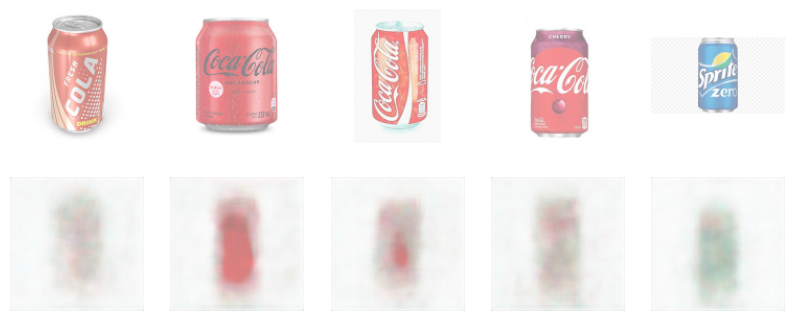

In [66]:
plot_reconstructions(vae, x_test)

## Parte 4: Demo Interactivo
Crear una interfaz gráfica interactiva para probar ambos modelos (DAE y VAE).

Se utilizará Gradio para la interfaz gráfica.

El demo deberá estar hosteado en Hugging Face Spaces.

In [67]:
# INTERFAZ

# Función para el Denoising Autoencoder (DAE)
def denoise_image(input_image):
    input_image = np.array(input_image) / 255.0  # Normalizar a [0, 1]
    input_image = input_image[np.newaxis, ...]  # Añadir dimensión de lote

    denoised_image = autoencoder.predict(input_image)  # Predecir imagen sin ruido
    denoised_image = (denoised_image[0] * 255).astype(np.uint8)

    return Image.fromarray(denoised_image)

# Función para el Variational Autoencoder (VAE)
def generate_image():
    random_latent_vector = np.random.normal(size=(1, 128))  # Asegurar tamaño correcto

    generated_image = decoder.predict(random_latent_vector)

    # Ajustar valores si la última capa del decoder usa tanh
    generated_image = (generated_image[0] * 255).astype(np.uint8)

    return Image.fromarray(generated_image)

# Crear la interfaz de Gradio
with gr.Blocks() as demo:
    gr.Markdown("# Interfaz para DAE y VAE")

    with gr.Tab("Denoising Autoencoder (DAE)"):
        gr.Markdown("Sube una imagen con ruido para ver su reconstrucción.")
        image_input = gr.Image(label="Imagen con ruido", type="pil")
        image_output = gr.Image(label="Imagen reconstruida", type="pil")
        denoise_button = gr.Button("Eliminar ruido")

    with gr.Tab("Variational Autoencoder (VAE)"):
        gr.Markdown("Genera una imagen sintética usando el VAE.")
        vae_output = gr.Image(label="Imagen generada", type="pil")
        generate_button = gr.Button("Generar imagen")

    denoise_button.click(fn=denoise_image, inputs=image_input, outputs=image_output)
    generate_button.click(fn=generate_image, inputs=None, outputs=vae_output)

# Lanzar la interfaz
demo.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://c9ff9508a40622d4b4.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [68]:
# Guardar el modelo

# Guardar el autoencoder
autoencoder.save("mi-autoencoder_final.h5")

# Guardar el decoder
decoder.save("mi-decoder_final.h5")

# Descargar mi-autoencoder.h5
files.download("mi-autoencoder_final.h5")

# Descargar mi-decoder.h5
files.download("mi-decoder_final.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>